# Part 4: Toward Learned Receivers

This tutorial will guide you through Sionna, from its basic principles to the implementation of a point-to-point link with a 5G NR compliant code and a 3GPP channel model.
You will also learn how to write custom trainable layers by implementing a state of the art neural receiver, and how to train and evaluate end-to-end communication systems.

The tutorial is structured in four notebooks:

- Part I: Getting started with Sionna

- Part II: Differentiable Communication Systems

- Part III: Advanced Link-level Simulations

- **Part IV: Toward Learned Receivers**

The [official documentation](https://nvlabs.github.io/sionna/phy) provides key material on how to use Sionna and how its components are implemented.

* [Imports](#Imports)
* [Simulation Parameters](#Simulation-Parameters)
* [Implemention of an Advanced Neural Receiver](#Implemention-of-an-Advanced-Neural-Receiver)
* [Training the Neural Receiver](#Training-the-Neural-Receiver)
* [Benchmarking the Neural Receiver](#Benchmarking-the-Neural-Receiver)
* [Conclusion](#Conclusion)

## Imports<a class="anchor" id="import"></a>

In [1]:
import os # Configure which GPU 
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna as sn
    import sionna.phy
except ImportError as e:
    import sys
    if 'google.colab' in sys.modules:
       # Install Sionna in Google Colab
       print("Installing Sionna and restarting the runtime. Please run the cell again.")
       os.system("pip install sionna")
       os.kill(os.getpid(), 5)
    else:
       raise e

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e) 

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

import numpy as np

# For saving complex Python data structures efficiently
import pickle

# For plotting
%matplotlib inline
import matplotlib.pyplot as plt

# For the implementation of the neural receiver
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Conv2D, LayerNormalization
from tensorflow.nn import relu

# Set seed for reproducable results
sn.phy.config.seed = 42

## Simulation Parameters

In [2]:
# Bit per channel use
NUM_BITS_PER_SYMBOL = 2 # QPSK

# Minimum value of Eb/N0 [dB] for simulations
EBN0_DB_MIN = -3.0

# Maximum value of Eb/N0 [dB] for simulations
EBN0_DB_MAX = 5.0

# How many examples are processed by Sionna in parallel
BATCH_SIZE = 128

# Coding rate
CODERATE = 0.5

# Define the number of UT and BS antennas
NUM_UT = 1
NUM_BS = 1
NUM_UT_ANT = 1
NUM_BS_ANT = 2

# The number of transmitted streams is equal to the number of UT antennas
# in both uplink and downlink
NUM_STREAMS_PER_TX = NUM_UT_ANT

# Create an RX-TX association matrix.
# RX_TX_ASSOCIATION[i,j]=1 means that receiver i gets at least one stream
# from transmitter j. Depending on the transmission direction (uplink or downlink),
# the role of UT and BS can change.
# For example, considering a system with 2 RX and 4 TX, the RX-TX
# association matrix could be
# [ [1 , 1, 0, 0],
#   [0 , 0, 1, 1] ]
# which indicates that the RX 0 receives from TX 0 and 1, and RX 1 receives from
# TX 2 and 3.
#
# In this notebook, as we have only a single transmitter and receiver,
# the RX-TX association matrix is simply:
RX_TX_ASSOCIATION = np.array([[1]])

# Instantiate a StreamManagement object
# This determines which data streams are determined for which receiver.
# In this simple setup, this is fairly easy. However, it can get more involved
# for simulations with many transmitters and receivers.
STREAM_MANAGEMENT = sn.phy.mimo.StreamManagement(RX_TX_ASSOCIATION, NUM_STREAMS_PER_TX)

RESOURCE_GRID = sn.phy.ofdm.ResourceGrid(num_ofdm_symbols=14,
                                         fft_size=76,
                                         subcarrier_spacing=30e3,
                                         num_tx=NUM_UT,
                                         num_streams_per_tx=NUM_STREAMS_PER_TX,
                                         cyclic_prefix_length=6,
                                         pilot_pattern="kronecker",
                                         pilot_ofdm_symbol_indices=[2,11])

# Carrier frequency in Hz.
CARRIER_FREQUENCY = 2.6e9

# Antenna setting
UT_ARRAY = sn.phy.channel.tr38901.Antenna(polarization="single",
                                          polarization_type="V",
                                          antenna_pattern="38.901",
                                          carrier_frequency=CARRIER_FREQUENCY)
BS_ARRAY = sn.phy.channel.tr38901.AntennaArray(num_rows=1,
                                               num_cols=int(NUM_BS_ANT/2),
                                               polarization="dual",
                                               polarization_type="cross",
                                               antenna_pattern="38.901", # Try 'omni'
                                               carrier_frequency=CARRIER_FREQUENCY)

# Nominal delay spread in [s]. Please see the CDL documentation
# about how to choose this value.
DELAY_SPREAD = 100e-9

# The `direction` determines if the UT or BS is transmitting.
# In the `uplink`, the UT is transmitting.
DIRECTION = "uplink"

# Suitable values are ["A", "B", "C", "D", "E"]
CDL_MODEL = "C"

# UT speed [m/s]. BSs are always assumed to be fixed.
# The direction of travel will chosen randomly within the x-y plane.
SPEED = 10.0

# Configure a channel impulse reponse (CIR) generator for the CDL model.
CDL = sn.phy.channel.tr38901.CDL(CDL_MODEL,
                                 DELAY_SPREAD,
                                 CARRIER_FREQUENCY,
                                 UT_ARRAY,
                                 BS_ARRAY,
                                 DIRECTION,
                                 min_speed=SPEED)

## Implemention of an Advanced Neural Receiver

We will implement a state-of-the-art neural receiver that operates over the entire resource grid of received symbols.

The neural receiver computes LLRs on the coded bits from the received resource grid of frequency-domain baseband symbols.

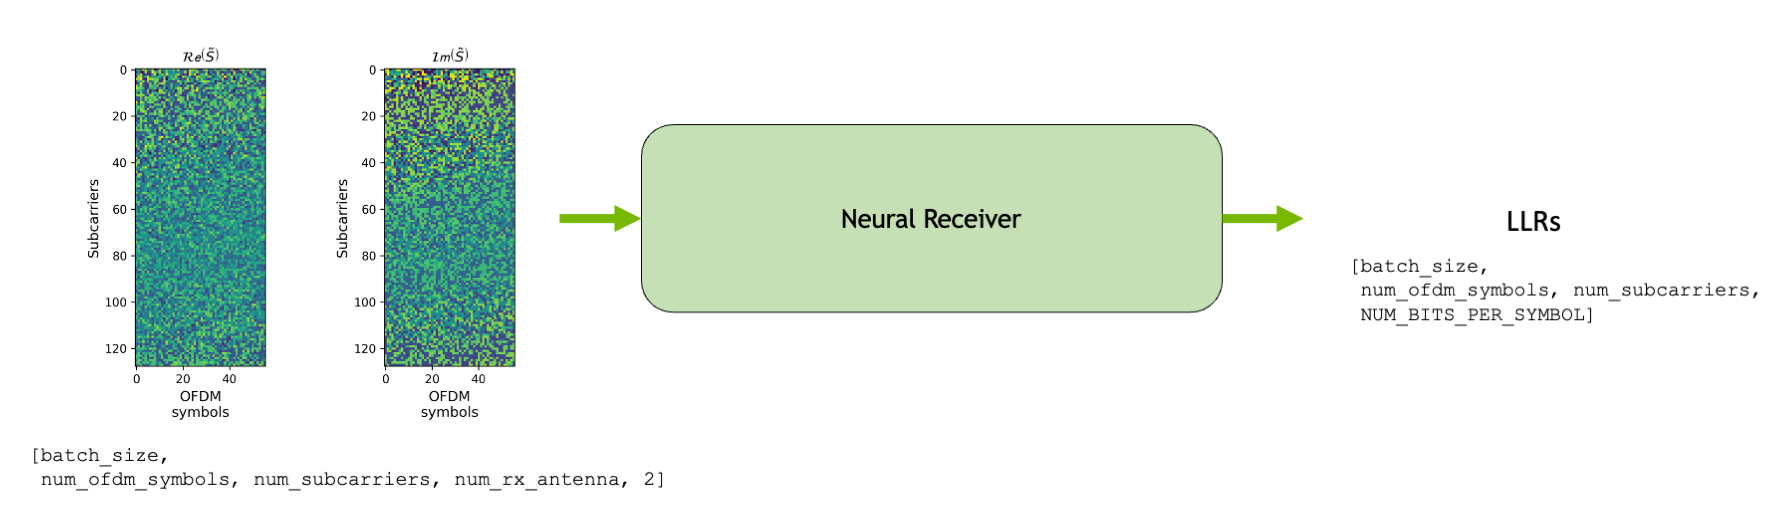

As shown in the following figure, the neural receiver substitutes to the channel estimator, equalizer, and demapper.

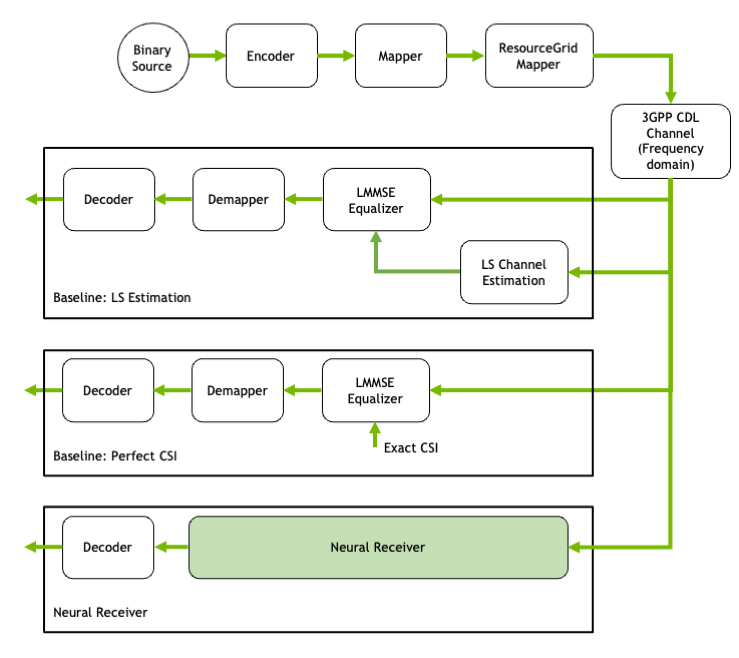

As in [1] and [2], a neural receiver using residual convolutional layers is implemented.

Convolutional layers are leveraged to efficienly process the 2D resource grid that is fed as an input to the neural receiver.

Residual (skip) connections are used to avoid gradient vanishing [3].

For convenience, a Keras layer that implements a *residual block* is first defined. The Keras layer that implements the neural receiver is built by stacking such blocks. The following figure shows the architecture of the neural receiver.

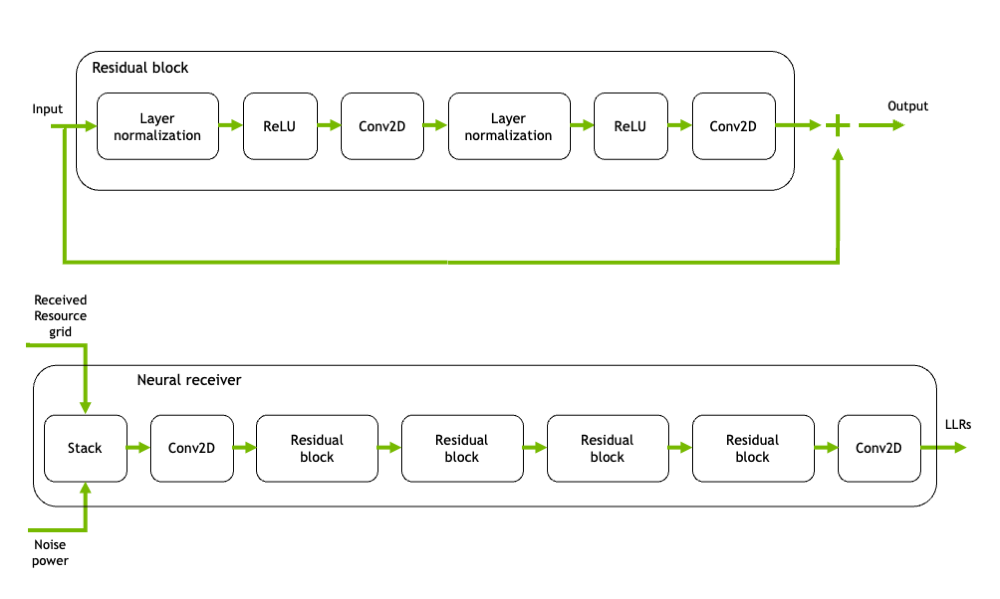

In [3]:
class ResidualBlock(Layer):

    def __init__(self):
        super().__init__()

        # Layer normalization is done over the last three dimensions: time, frequency, conv 'channels'
        self._layer_norm_1 = LayerNormalization(axis=(-1, -2, -3))
        self._conv_1 = Conv2D(filters=128,
                              kernel_size=[3,3],
                              padding='same',
                              activation=None)
        # Layer normalization is done over the last three dimensions: time, frequency, conv 'channels'
        self._layer_norm_2 = LayerNormalization(axis=(-1, -2, -3))
        self._conv_2 = Conv2D(filters=128,
                              kernel_size=[3,3],
                              padding='same',
                              activation=None)

    def call(self, inputs):
        z = self._layer_norm_1(inputs)
        z = relu(z)
        z = self._conv_1(z)
        z = self._layer_norm_2(z)
        z = relu(z)
        z = self._conv_2(z) # [batch size, num time samples, num subcarriers, num_channels]
        # Skip connection
        z = z + inputs

        return z

class NeuralReceiver(Layer):

    def __init__(self):
        super().__init__()

        # Input convolution
        self._input_conv = Conv2D(filters=128,
                                  kernel_size=[3,3],
                                  padding='same',
                                  activation=None)
        # Residual blocks
        self._res_block_1 = ResidualBlock()
        self._res_block_2 = ResidualBlock()
        self._res_block_3 = ResidualBlock()
        self._res_block_4 = ResidualBlock()
        # Output conv
        self._output_conv = Conv2D(filters=NUM_BITS_PER_SYMBOL,
                                   kernel_size=[3,3],
                                   padding='same',
                                   activation=None)

    def call(self, y, no):

        # Assuming a single receiver, remove the num_rx dimension
        y = tf.squeeze(y, axis=1)

        # Feeding the noise power in log10 scale helps with the performance
        no = sn.phy.utils.log10(no)

        # Stacking the real and imaginary components of the different antennas along the 'channel' dimension
        y = tf.transpose(y, [0, 2, 3, 1]) # Putting antenna dimension last
        no = sn.phy.utils.insert_dims(no, 3, 1)
        no = tf.tile(no, [1, y.shape[1], y.shape[2], 1])
        # z : [batch size, num ofdm symbols, num subcarriers, 2*num rx antenna + 1]
        z = tf.concat([tf.math.real(y),
                       tf.math.imag(y),
                       no], axis=-1)
        # Input conv
        z = self._input_conv(z)
        # Residual blocks
        z = self._res_block_1(z)
        z = self._res_block_2(z)
        z = self._res_block_3(z)
        z = self._res_block_4(z)
        # Output conv
        z = self._output_conv(z)

        # Reshape the input to fit what the resource grid demapper is expected
        z = sn.phy.utils.insert_dims(z, 2, 1)

        return z

The task of the receiver is to jointly solve, for each resource element, `NUM_BITS_PER_SYMBOL` binary classification problems in order to reconstruct the transmitted bits.
Therefore, a natural choice for the loss function is the *binary cross-entropy* (BCE) applied to each bit and to each received symbol.

*Remark:* The LLRs computed by the demapper are *logits* on the transmitted bits, and can therefore be used as-is to compute the BCE without any additional processing.
*Remark 2:* The BCE is closely related to an achieveable information rate for bit-interleaved coded modulation systems [4,5]

The next cell defines an end-to-end communication system using the neural receiver layer.

At initialization, the paramater `training` indicates if the system is instantiated to be trained (`True`) or evaluated (`False`).

If the system is instantiated to be trained, the outer encoder and decoder are not used as they are not required for training. Moreover, the estimated BCE is returned.
This significantly reduces the computational complexity of training.

If the system is instantiated to be evaluated, the outer encoder and decoder are used, and the transmited information and corresponding LLRs are returned.

In [4]:
class OFDMSystemNeuralReceiver(Model): # Inherits from Keras Model

    def __init__(self, training):
        super().__init__() # Must call the Keras model initializer

        self.training = training

        n = int(RESOURCE_GRID.num_data_symbols*NUM_BITS_PER_SYMBOL) # Number of coded bits
        k = int(n*CODERATE) # Number of information bits
        self.k = k
        self.n = n

        # The binary source will create batches of information bits
        self.binary_source = sn.phy.mapping.BinarySource()

        # The encoder maps information bits to coded bits
        self.encoder = sn.phy.fec.ldpc.LDPC5GEncoder(k, n)

        # The mapper maps blocks of information bits to constellation symbols
        self.mapper = sn.phy.mapping.Mapper("qam", NUM_BITS_PER_SYMBOL)

        # The resource grid mapper maps symbols onto an OFDM resource grid
        self.rg_mapper = sn.phy.ofdm.ResourceGridMapper(RESOURCE_GRID)

        # Frequency domain channel
        self.channel = sn.phy.channel.OFDMChannel(CDL, RESOURCE_GRID, add_awgn=True, normalize_channel=True, return_channel=False)

        # Neural receiver
        self.neural_receiver = NeuralReceiver()

        # Used to extract data-carrying resource elements
        self.rg_demapper = sn.phy.ofdm.ResourceGridDemapper(RESOURCE_GRID, STREAM_MANAGEMENT)

        # The decoder provides hard-decisions on the information bits
        self.decoder = sn.phy.fec.ldpc.LDPC5GDecoder(self.encoder, hard_out=True)

        # Loss function
        self.bce = tf.keras.losses.BinaryCrossentropy(from_logits=True) # Loss function

    @tf.function # Graph execution to speed things up
    def __call__(self, batch_size, ebno_db):
        no = sn.phy.utils.ebnodb2no(ebno_db, num_bits_per_symbol=NUM_BITS_PER_SYMBOL, coderate=CODERATE, resource_grid=RESOURCE_GRID)

        # The neural receiver is expected no to have shape [batch_size].
        if len(no.shape) == 0:
            no = tf.fill([batch_size], no)

        # Transmitter
        # Outer coding is only performed if not training
        if self.training:
            codewords = self.binary_source([batch_size, NUM_UT, NUM_UT_ANT, self.n])
        else:
            bits = self.binary_source([batch_size, NUM_UT, NUM_UT_ANT, self.k])
            codewords = self.encoder(bits)
        x = self.mapper(codewords)
        x_rg = self.rg_mapper(x)

        # Channel
        y = self.channel(x_rg, no)

        # Receiver
        llr = self.neural_receiver(y, no)
        llr = self.rg_demapper(llr) # Extract data-carrying resource elements. The other LLrs are discarded
        llr = tf.reshape(llr, [batch_size, NUM_UT, NUM_UT_ANT, self.n]) # Reshape the LLRs to fit what the outer decoder is expected
        if self.training:
            loss = self.bce(codewords, llr)
            return loss
        else:
            bits_hat = self.decoder(llr)
            return bits, bits_hat

## Training the Neural Receiver

The next cell implements a training loop of `NUM_TRAINING_ITERATIONS` iterations.

At each iteration:
- A batch of SNRs $E_b/N_0$ is sampled
- A forward pass through the end-to-end system is performed within a gradient tape
- The gradients are computed using the gradient tape, and applied using the Adam optimizer
- A progress bar is periodically updated to follow the progress of training

After training, the weights of the models are saved in a file using [pickle](https://docs.python.org/3/library/pickle.html).

Executing the next cell will take quite a while. If you do not want to train your own neural receiver, you can download the weights [here](https://drive.google.com/file/d/15txi7jAgSYeg8ylx5BAygYnywcGFw9WH/view?usp=sharing) and use them later on.

In [5]:
train = False # Chane to train your own model
if train :
    # Number of iterations used for training
    NUM_TRAINING_ITERATIONS = 100000

    # Instantiating the end-to-end model for training
    model = OFDMSystemNeuralReceiver(training=True)

    # Adam optimizer (SGD variant)
    optimizer = tf.keras.optimizers.Adam()

    # Training loop
    for i in range(NUM_TRAINING_ITERATIONS):
        # Sample a batch of SNRs.
        ebno_db = tf.random.uniform(shape=[BATCH_SIZE], minval=EBN0_DB_MIN, maxval=EBN0_DB_MAX)
        # Forward pass
        with tf.GradientTape() as tape:
            loss = model(BATCH_SIZE, ebno_db)
        # Computing and applying gradients
        weights = model.trainable_weights
        grads = tape.gradient(loss, weights)
        optimizer.apply_gradients(zip(grads, weights))
        # Print progress
        if i % 100 == 0:
            print(f"{i}/{NUM_TRAINING_ITERATIONS}  Loss: {loss:.2E}", end="\r")
    # Save the weightsin a file
    weights = model.get_weights()
    with open('weights-ofdm-neuralrx', 'wb') as f:
        pickle.dump(weights, f)

## Benchmarking the Neural Receiver

We evaluate the trained model and benchmark it against the previously introduced baselines.

We first define and evaluate the baselines.

In [6]:
class OFDMSystem(Model): # Inherits from Keras Model

    def __init__(self, perfect_csi):
        super().__init__() # Must call the Keras model initializer

        self.perfect_csi = perfect_csi

        n = int(RESOURCE_GRID.num_data_symbols*NUM_BITS_PER_SYMBOL) # Number of coded bits
        k = int(n*CODERATE) # Number of information bits
        self.k = k

        # The binary source will create batches of information bits
        self.binary_source = sn.phy.mapping.BinarySource()

        # The encoder maps information bits to coded bits
        self.encoder = sn.phy.fec.ldpc.LDPC5GEncoder(k, n)

        # The mapper maps blocks of information bits to constellation symbols
        self.mapper = sn.phy.mapping.Mapper("qam", NUM_BITS_PER_SYMBOL)

        # The resource grid mapper maps symbols onto an OFDM resource grid
        self.rg_mapper = sn.phy.ofdm.ResourceGridMapper(RESOURCE_GRID)

        # Frequency domain channel
        self.channel = sn.phy.channel.OFDMChannel(CDL, RESOURCE_GRID, add_awgn=True, normalize_channel=True, return_channel=True)

        # The LS channel estimator will provide channel estimates and error variances
        self.ls_est = sn.phy.ofdm.LSChannelEstimator(RESOURCE_GRID, interpolation_type="nn")

        # The LMMSE equalizer will provide soft symbols together with noise variance estimates
        self.lmmse_equ = sn.phy.ofdm.LMMSEEqualizer(RESOURCE_GRID, STREAM_MANAGEMENT)

        # The demapper produces LLR for all coded bits
        self.demapper = sn.phy.mapping.Demapper("app", "qam", NUM_BITS_PER_SYMBOL)

        # The decoder provides hard-decisions on the information bits
        self.decoder = sn.phy.fec.ldpc.LDPC5GDecoder(self.encoder, hard_out=True)

    @tf.function # Graph execution to speed things up
    def __call__(self, batch_size, ebno_db):
        no = sn.phy.utils.ebnodb2no(ebno_db, num_bits_per_symbol=NUM_BITS_PER_SYMBOL, coderate=CODERATE, resource_grid=RESOURCE_GRID)

        # Transmitter
        bits = self.binary_source([batch_size, NUM_UT, RESOURCE_GRID.num_streams_per_tx, self.k])
        codewords = self.encoder(bits)
        x = self.mapper(codewords)
        x_rg = self.rg_mapper(x)

        # Channel
        y, h_freq = self.channel(x_rg, no)

        # Receiver
        if self.perfect_csi:
            h_hat, err_var = h_freq, 0.
        else:
            h_hat, err_var = self.ls_est (y, no)
        x_hat, no_eff = self.lmmse_equ(y, h_hat, err_var, no)
        llr = self.demapper(x_hat, no_eff)
        bits_hat = self.decoder(llr)

        return bits, bits_hat

In [7]:
ber_plots = sn.phy.utils.PlotBER("Advanced neural receiver")

baseline_ls = OFDMSystem(False)
ber_plots.simulate(baseline_ls,
                  ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 20),
                  batch_size=BATCH_SIZE,
                  num_target_block_errors=100, # simulate until 100 block errors occured
                  legend="Baseline: LS Estimation",
                  soft_estimates=True,
                  max_mc_iter=100, # run 100 Monte-Carlo simulations (each with batch_size samples)
                  show_fig=False);

baseline_pcsi = OFDMSystem(True)
ber_plots.simulate(baseline_pcsi,
                  ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 20),
                  batch_size=BATCH_SIZE,
                  num_target_block_errors=100, # simulate until 100 block errors occured
                  legend="Baseline: Perfect CSI",
                  soft_estimates=True,
                  max_mc_iter=100, # run 100 Monte-Carlo simulations (each with batch_size samples)
                  show_fig=False);

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -3.0 | 3.6858e-01 | 1.0000e+00 |       43026 |      116736 |          128 |         128 |        10.8 |reached target block errors
   -2.579 | 3.5468e-01 | 1.0000e+00 |       41404 |      116736 |          128 |         128 |         0.1 |reached target block errors
   -2.158 | 3.4774e-01 | 1.0000e+00 |       40594 |      116736 |          128 |         128 |         0.1 |reached target block errors
   -1.737 | 3.3398e-01 | 1.0000e+00 |       38987 |      116736 |          128 |         128 |         0.1 |reached target block errors
   -1.316 | 3.2021e-01 | 1.0000e+00 |       37380 |      116736 |          128 |         128 |         0.1 |reached target block errors
   -0.895 | 3.0953e-01 | 1.0000e+00 |       36133 |      116736 |

We then instantiate and evaluate the end-to-end system equipped with the neural receiver.

In [8]:
# Instantiating the end-to-end model for evaluation
model_neuralrx = OFDMSystemNeuralReceiver(training=False)

# Run one inference to build the layers and loading the weights
model_neuralrx(tf.constant(1, tf.int32), tf.constant(10.0, tf.float32))
with open('weights-ofdm-neuralrx', 'rb') as f:
    weights = pickle.load(f)
    model_neuralrx.set_weights(weights)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -3.0 | 2.2353e-01 | 1.0000e+00 |       26094 |      116736 |          128 |         128 |         0.3 |reached target block errors
   -2.579 | 2.0426e-01 | 1.0000e+00 |       23845 |      116736 |          128 |         128 |         0.1 |reached target block errors
   -2.158 | 1.8083e-01 | 1.0000e+00 |       21109 |      116736 |          128 |         128 |         0.1 |reached target block errors
   -1.737 | 1.5117e-01 | 1.0000e+00 |       17647 |      116736 |          128 |         128 |         0.1 |reached target block errors
   -1.316 | 7.8176e-02 | 9.2188e-01 |        9126 |      116736 |          118 |         128 |         0.1 |reached target block errors
   -0.895 | 2.7661e-02 | 5.3125e-01 |        6458 |      233472 |

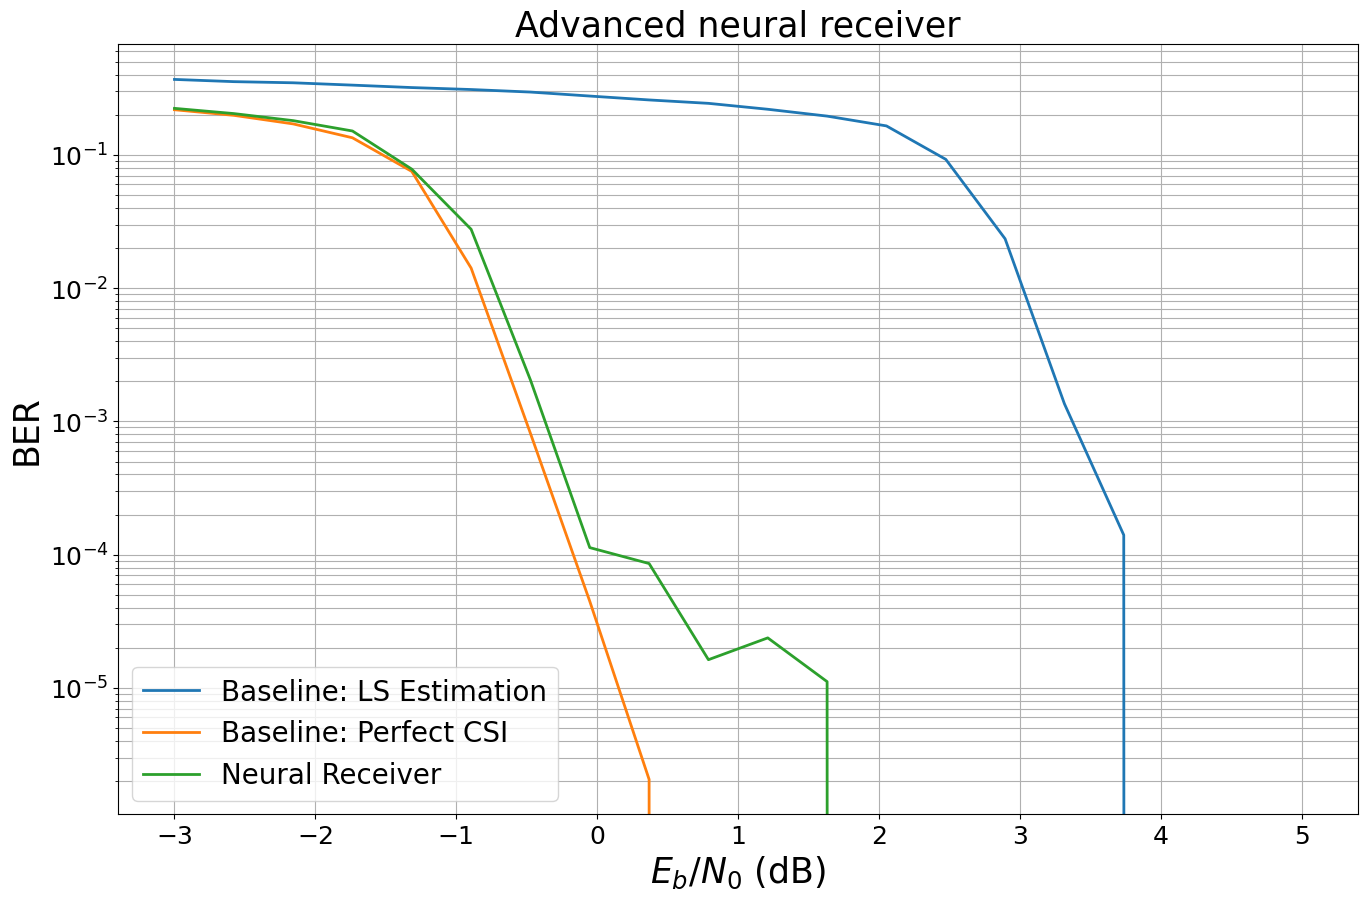

In [9]:
# Computing and plotting BER
ber_plots.simulate(model_neuralrx,
                  ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 20),
                  batch_size=BATCH_SIZE,
                  num_target_block_errors=100,
                  legend="Neural Receiver",
                  soft_estimates=True,
                  max_mc_iter=100,
                  show_fig=True);

## Conclusion <a class="anchor" id="Conclusion"></a>

We hope you are excited about Sionna - there is much more to be discovered:

- TensorBoard debugging available
- Scaling to multi-GPU simulation is simple
- See the [available tutorials](https://nvlabs.github.io/sionna/phy/tutorials.html) for more examples

And if something is still missing - the project is open-source: you can modify, add, and extend any component at any time.

## References

[1] [M. Honkala, D. Korpi and J. M. J. Huttunen, "DeepRx: Fully Convolutional Deep Learning Receiver," in IEEE Transactions on Wireless Communications, vol. 20, no. 6, pp. 3925-3940, June 2021, doi: 10.1109/TWC.2021.3054520](https://ieeexplore.ieee.org/abstract/document/9345504).

[2] [F. Ait Aoudia and J. Hoydis, "End-to-end Learning for OFDM: From Neural Receivers to Pilotless Communication," in IEEE Transactions on Wireless Communications, doi: 10.1109/TWC.2021.3101364](https://ieeexplore.ieee.org/abstract/document/9508784).

[3] [Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, "Deep Residual Learning for Image Recognition", Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2016, pp. 770-778](https://openaccess.thecvf.com/content_cvpr_2016/html/He_Deep_Residual_Learning_CVPR_2016_paper.html)